<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Introducing the Qiskit Transpiler

## Introduction

In this notebook we introduce the Qiskit transpiler and walk through some examples of circuit transformations using **transpiler passes**.

The transpiler is Qiskit's circuit-rewriting framework. We intentionally do not call it a "compiler", since we use compiler in the context of a larger translation from high-level applications (potentially many circuits, with classical control flow between them) down to the level of machine pulses. The transpiler, in contrast, is responsible only for circuit-level analysis and transformations.

Circuits are a fundamental and universal model of computation on quantum computers. In the Noisy Intermediate-Scale Quantum (NISQ) regime, we are always limited by the scarcity of quantum resources. The transpiler is a tool that helps us reduce the number of gates and qubits, in order to increase the fidelity of executions.

Circuit optimization is a difficult task (in general QMA-complete). To make it approachable, we break it down. Each transpiler pass is thus responsible for doing one small, well-defined task. Through this "separation of responsibilities", we are able to chain together different passes to achieve an aggressive optimization goal.

Which passes are chained together and in which order has a major effect on the final outcome. This pipeline is determined by a **pass manager**, which schedules the passes and also allows passes to communicate with each other by providing a shared space.

## Transpiler API

There are two main ways to use the transpiler:
1. Use the ``transpile()`` function, and specify some desired transpilation options, like ``basis_gates``, ``coupling_map``, ``initial_layout`` of qubits, or ``optimization_level``.

2. Create your own custom pass manager.

In [1]:
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

Let's start with a very simple transpilation task. Suppose we have a single Toffoli gate that we want to unroll to a more fundamental basis.

In [2]:
from qiskit import QuantumRegister, QuantumCircuit
q = QuantumRegister(3, 'q')
circ = QuantumCircuit(q)
circ.ccx(q[0], q[1], q[2])
circ.draw()

### *transpile( ) function*

This function is a convenience function, allowing the user to quickly transpile a circuit with minimal effort. Refer to the function documentation for more info.

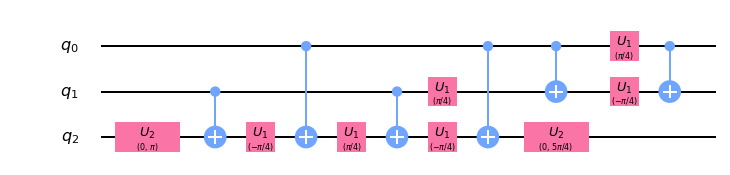

In [3]:
new_circ = transpile(circ, basis_gates=['u1', 'u3', 'u2', 'cx'])
new_circ.draw(output='mpl')

### *PassManager object*

This lets you specify the passes you want.

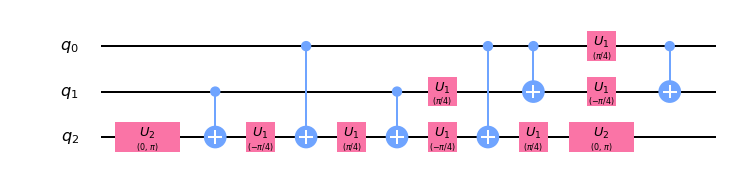

In [4]:
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(circ)
new_circ.draw(output='mpl')

All of Qiskit's transpiler passes are accessible from ``qiskit.transpiler.passes``.

In [5]:
from qiskit.transpiler import passes
[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ApplyLayout',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckMap',
 'Collect2qBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'ConsolidateBlocks',
 'CountOps',
 'CountOpsLongestPath',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'EnlargeWithAncilla',
 'FixedPoint',
 'FullAncillaAllocation',
 'LookaheadSwap',
 'MergeAdjacentBarriers',
 'NoiseAdaptiveLayout',
 'NumTensorFactors',
 'Optimize1qGates',
 'OptimizeSwapBeforeMeasure',
 'RemoveDiagonalGatesBeforeMeasure',
 'RemoveResetInZeroState',
 'ResourceEstimation',
 'SetLayout',
 'Size',
 'StochasticSwap',
 'TrivialLayout',
 'Unroll3qOrMore',
 'Unroller',
 'Width']

## Different Variants of the Same Pass

There can be passes that do the same job, but in different ways. For example, the ``TrivialLayout``, ``DenseLayout`` and ``NoiseAdaptiveLayout`` all choose a layout (binding of virtual qubits to physical qubits), but use different algorithms and objectives. Similarly, the ``BasicSwap``, ``LookaheadSwap`` and ``StochasticSwap`` all insert swaps to make the circuit compatible with the coupling map. The modularity of the transpiler allows plug-and-play replacements for each pass.

Below, we show the swapper passes all applied to the same circuit, to transform it to match a linear chain topology. You can see differences in performance, where the StochasticSwap is clearly the best. However, this can vary depending on the input circuit.

In [6]:
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap

coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

qr = QuantumRegister(7, 'q')
circuit = QuantumCircuit(qr)
circuit.h(qr[3])
circuit.cx(qr[0], qr[6])
circuit.cx(qr[6], qr[0])
circuit.cx(qr[0], qr[1])
circuit.cx(qr[3], qr[1])
circuit.cx(qr[3], qr[0])

coupling_map = CouplingMap(couplinglist=coupling)
layout = Layout({qr[i]: i for i in range(coupling_map.size())})

bs = BasicSwap(coupling_map=coupling_map)
pass_manager = PassManager(bs)
basic_circ = pass_manager.run(circuit)

ls = LookaheadSwap(coupling_map=coupling_map)
pass_manager = PassManager(ls)
lookahead_circ = pass_manager.run(circuit)

ss = StochasticSwap(coupling_map=coupling_map)
pass_manager = PassManager(ss)
stochastic_circ = pass_manager.run(circuit)

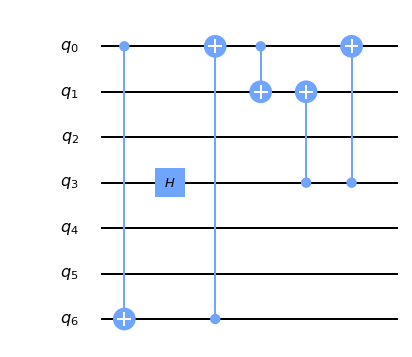

In [7]:
circuit.draw(output='mpl')

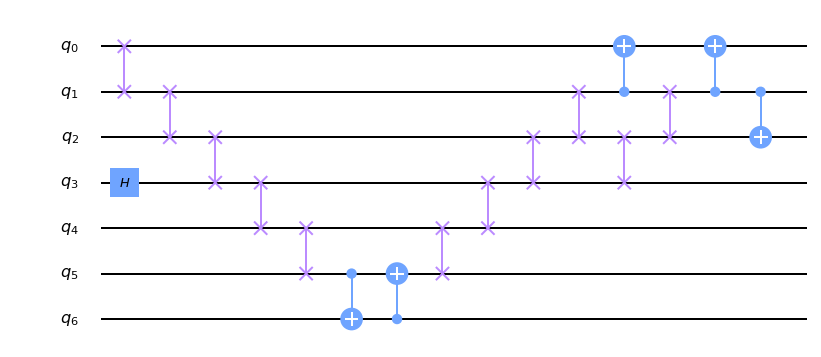

In [8]:
basic_circ.draw(output='mpl')

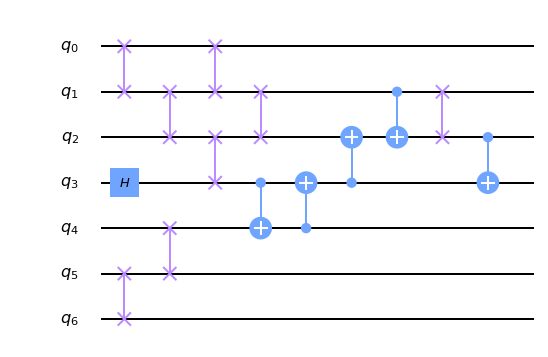

In [9]:
lookahead_circ.draw(output='mpl')

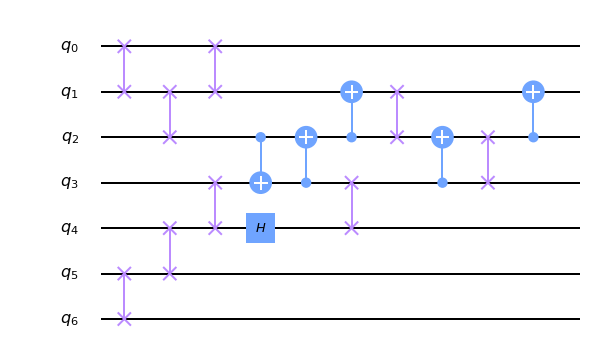

In [10]:
stochastic_circ.draw(output='mpl')

## Preset Pass Managers

Qiskit comes with several pre-defined pass managers, corresponding to various levels of optimization achieved through different pipelines of passes. Currently ``optimization_level`` 0 through 3 are supported; the higher the number, the more optimized it is, at the expense of more time. Choosing a good pass manager may take trial and error, as it depends heavily on the circuit being transpiled and the backend being targeted.

Here we illustrate the different levels by looking at a state synthesis circuit. We initialize four qubits to an arbitrary state, and then try to optimize the circuit that achieves this.

- ``optimization_level=0``: just maps the circuit to the backend, with no explicit optimization (except whatever optimizations the mapper does).

- ``optimization_level=1``: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

- ``optimization_level=2``: medium-weight optimization, including a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships.

- ``optimization_level=3``: heavy-weight optimization, which in addition to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

In [11]:
import math
from qiskit.test.mock import FakeTokyo

qr = QuantumRegister(10)
qc = QuantumCircuit(qr)

backend = FakeTokyo()     # mimics the tokyo device in terms of coupling map and basis gates
backend.properties = {}   # remove fake properties

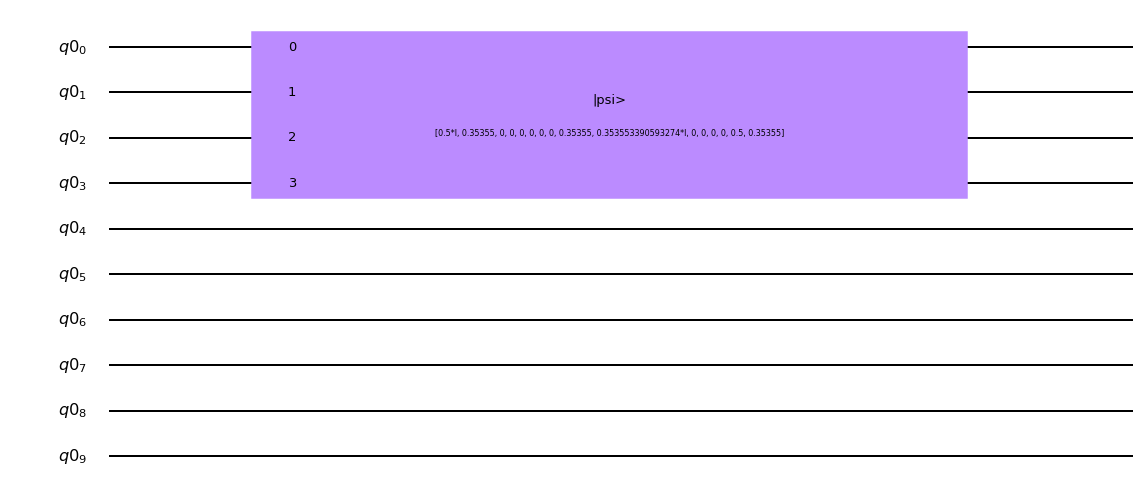

In [12]:
random_state = [
    1 / math.sqrt(4) * complex(0, 1),
    1 / math.sqrt(8) * complex(1, 0),
    0,
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(8) * complex(1, 0),
    1 / math.sqrt(8) * complex(0, 1),
    0,
    0,
    0,
    0,
    1 / math.sqrt(4) * complex(1, 0),
    1 / math.sqrt(8) * complex(1, 0)]

qc.initialize(random_state, qr[0:4])
qc.draw(output='mpl')

Now map this to the 20-qubit Tokyo device, with different optimization levels:

In [13]:
optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

gates =  OrderedDict([('cx', 86), ('u3', 15), ('u1', 15)])
depth =  102


In [14]:
optimized_1 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=1)
print('gates = ', optimized_1.count_ops())
print('depth = ', optimized_1.depth())

gates =  OrderedDict([('cx', 80), ('u3', 15), ('u1', 10)])
depth =  91


In [15]:
optimized_2 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=2)
print('gates = ', optimized_2.count_ops())
print('depth = ', optimized_2.depth())

gates =  OrderedDict([('cx', 74), ('u3', 15), ('u1', 6), ('u2', 4)])
depth =  81


In [16]:
optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('cx', 70), ('u3', 28), ('u2', 15), ('u1', 4)])
depth =  84


You can see that the circuit gets progressively better (both in terms of depth and the number of expensive cx gates).